This requires data generated using `pipeline/1.generate_critical_events.py`

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cmap
import matplotlib as mpl
import yt
import pandas as pd
import xarray
from tqdm.autonotebook import tqdm
from glob import glob
from sklearn.neighbors import KDTree, dist_metrics
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from collections import defaultdict
import treecorr
from py_constr_field import field, filters

In [102]:
ds['iR'].min()

<xarray.DataArray 'iR' ()>
array(1)

In [105]:
sigma[ds['iR']-1].shape

(26326,)

In [106]:
ds['iR'].shape

(26326,)

In [111]:
all_files = sorted(glob('data/*_crit_events.nc'), key=lambda e: int(e.split('/')[-1].split('_')[0]))
all_ds = []
all_ds_by_ns = defaultdict(list)
stats = defaultdict(lambda: 0)
k = np.geomspace(1e-4, 1e4, 1000)
Rmin = 1
Rmax = 5
for f in tqdm(all_files):
    ds = xarray.open_dataset(f)
    pix2Mpc = ds.attrs["Lbox"] / ds.attrs['dimensions']
    fh = field.FieldHandler(Ndim=3, Lbox=ds.attrs['Lbox'], dimensions=16,
                            Pk=(k, k**ds.attrs['spectral_index']), filter=filters.TopHatFilter(radius=8))
    smoothing_scales = np.geomspace(*ds.attrs['smoothing_scale'])
    sigma = np.array([fh.sigma(0, filters.GaussianFilter(radius=R*pix2Mpc)) for R in smoothing_scales])
    
    iR = ds.iR.values.astype(int)
    dummy_val = ds['iR'] * 0 
    # ds['sigma'] = dummy_val + sigma[ds.iR] 
    # ds['sigma'] = dummy_val + sigma[ds['iR'].values-1]
    ds['nu'] = ds['dens'] / ds['sigma']
    R = ds.R * pix2Mpc
    DeltaR_tot = Rmax - Rmin
    DeltaR = (smoothing_scales[iR] - smoothing_scales[iR-1])
    pix2Mpc = ds.attrs['Lbox'] / ds.attrs['dimensions']
    Vbox = ds.attrs['Lbox']**3
    
    ds['weight'] = dummy_val + R**4 / DeltaR / DeltaR_tot / Vbox
    ds['four_density'] = 1 / (DeltaR/R) / (Vbox/R**3)
    
    ################################################################
    #  RANDOMLY SWAP KIND TO REMOVE BIAS
    ################################################################
    if np.random.rand() > 0.5:
        ds['kind'] = 2-ds['kind']
        ds['nu'] = -ds['nu']
        ds['dens'] = -ds['dens']

    all_ds.append(ds)
    all_ds_by_ns[ds.attrs["spectral_index"]].append(ds)
    stats[ds.attrs["spectral_index"]] += 1

for k in all_ds_by_ns:
    new = xarray.auto_combine(all_ds_by_ns[k])
    new.attrs.update(all_ds_by_ns[k][0].attrs)
    all_ds_by_ns[k] = new
    print(f'Number of cube found for ns={k}: {stats[k]}')
critical_events = all_ds_by_ns


Number of cube found for ns=0: 22
Number of cube found for ns=-2.0: 22
Number of cube found for ns=-1.5: 19
Number of cube found for ns=-1.0: 19
Number of cube found for ns=-0.5: 21


# Number counts of critical event
According to theory, the number count scales as 
$$ \frac{\partial^2 n}{\partial R\partial \nu} \sim \frac{\alpha}{R^4}\quad \Leftrightarrow \quad \frac{\partial^5 \mathcal{N}}{\partial \log R \partial(x/R)^3\partial\nu} = \alpha.$$

$$ \alpha = \frac{1}{\Delta \nu \sum \Delta\log R} \sum_{R_0} N(R_0\leq R < R_0f) \left(\frac{R}{L}\right)^3
$$

In [162]:
smoothing_scales[35] * 2.56

21.754399769188772

In [188]:
nubins = np.linspace(-4, 4, 50)
fourdens0, fourdens1, fourdens2 = [defaultdict(lambda: np.zeros(len(nubins)-1)) for _ in range(3)]
tmp0, tmp1, tmp2 = [defaultdict(list) for _ in range(3)]
w0, w1, w2 = [defaultdict(lambda: np.zeros(len(nubins)-1)) for _ in range(3)]
wp0, wp1, wp2 = [defaultdict(lambda: np.zeros(len(nubins)-1)) for _ in range(3)]

alpha = 1
for ns, ds in tqdm(all_ds_by_ns.items()):
    count = 0
    smoothing_scales = np.geomspace(*ds.attrs['smoothing_scale'])
    wp0, wp1, wp2 = [np.zeros(len(nubins)-1) for _ in range(3)]
    for i in range(15, 35):
        dss = ds.where(ds.iR == i)
        ds0 = dss.where((dss.kind == 0))
        ds1 = dss.where((dss.kind == 1))
        ds2 = dss.where((dss.kind == 2))
        
        Rmax = smoothing_scales[i]
        Rmin = smoothing_scales[i-1]

        dR = Rmax - Rmin
        Rmed = (Rmax + Rmin) / 2
        Vtot = ds.attrs['Lbox']**3
        dnu = nubins[1] - nubins[0]

        N, _ = np.histogram(ds0.nu.values, bins=nubins)
        v = N**(1+alpha) / Vtot / dR * Rmed**4 / dnu
        tmp0[ns].append(v)
        fourdens0[ns] += v
        w0[ns] += N**alpha
        wp0 += N**alpha

        N, _ = np.histogram(ds1.nu.values, bins=nubins)
        v = N**(1+alpha) / Vtot / dR * Rmed**4 / dnu
        tmp1[ns].append(v)
        fourdens1[ns] += v
        w1[ns] += N**alpha
        wp1 += N**alpha

        N, _ = np.histogram(ds2.nu.values, bins=nubins)
        v = N**(1+alpha) / Vtot / dR * Rmed**4 / dnu
        tmp2[ns].append(v)
        fourdens2[ns] += v
        w2[ns] += N**alpha
        wp2 += N**alpha
        
        count += 1

    fourdens0[ns] = np.where(w0[ns] > 0, fourdens0[ns]/w0[ns], 0)
    fourdens1[ns] = np.where(w1[ns] > 0, fourdens1[ns]/w1[ns], 0)
    fourdens2[ns] = np.where(w2[ns] > 0, fourdens2[ns]/w2[ns], 0)
    
    tmp0[ns] /= wp0
    tmp1[ns] /= wp1
    tmp2[ns] /= wp2

/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWa

Estimate errors using sample

In [189]:
err0, err1, err2 = [{} for _ in range(3)]
err = {}
for ns in tmp0:
    data = np.array(tmp0[ns])
    err0[ns] = np.std(data, axis=0)
    
    data = np.array(tmp1[ns])
    err1[ns] = np.std(data, axis=0)
    
    data = np.array(tmp2[ns])
    err2[ns] = np.std(data, axis=0)

In [194]:
 tmp0[-2].mean(axis=0)

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 7.16983371e-05, 3.10991318e-04,
                  nan,            nan, 3.56282693e-04, 2.36364840e-04,
       3.60341743e-04, 4.33434365e-04, 9.65007838e-04, 1.25835544e-03,
       1.60664457e-03, 2.77886794e-03, 3.16373966e-03, 4.13791363e-03,
       5.94196585e-03, 6.85151886e-03, 7.92461333e-03, 9.43548018e-03,
       1.02804831e-02, 1.02926353e-02, 1.10405944e-02, 1.02285052e-02,
       1.00944873e-02, 8.83898237e-03, 7.62523929e-03, 6.44595426e-03,
       5.97583643e-03, 4.64447618e-03, 3.67534663e-03, 2.90786192e-03,
       2.22554398e-03, 1.42790436e-03, 1.19402465e-03, 9.55552805e-04,
       4.97403322e-04, 2.82926792e-04, 4.07357958e-04, 1.37031369e-04,
       3.10991318e-04])

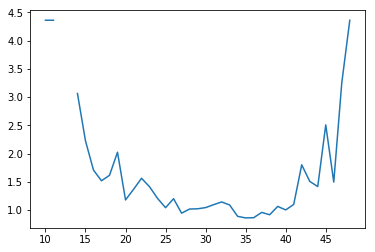

In [195]:
plt.plot(err0[-2]/ tmp0[-2].mean(axis=0))

## Theoretical curves

In [46]:
from numba import njit
from scipy.integrate import dblquad, quad, tplquad
from functools import lru_cache

@lru_cache(0)
def oddpart(ns):
    '''Computes <|x333| |x3ii|>.'''
    zeta = np.sqrt((ns+5)/(ns+7))
    return (np.sqrt(1.5)*(4*np.sqrt(21)*np.sqrt(1 - zeta**2) - 21*np.pi*(-1 + zeta**2)
                          + 42*(-1 + zeta**2)*np.arctan(2/(np.sqrt(21)*np.sqrt(1 - zeta**2)))))/(70.*np.pi**2.5)
# def oddpart2(ns):
#     # We checked that this yields the same result as above
#     zeta = np.sqrt((ns+5)/(ns+7))
#     return (3*np.sqrt(1.5)*(1 - zeta**2))/(5.*np.pi**2.5) * (np.pi/2. + 2/(np.sqrt(21)*np.sqrt(1 - zeta**2)) - np.arctan(2/(np.sqrt(21)*np.sqrt(1 - zeta**2))))

@njit
def intgdodd(x113, x223, x333, ns):
    '''This is the PDF of (x113, x223, x333 | x1=x2=x3=0)'''
    zeta = np.sqrt((ns+5)/(ns+7))
    pdf = ((105*np.sqrt(2.5)*np.exp((x113**2*(45 - 42*zeta**2) + x223**2*(45 - 42*zeta**2) + x333**2*(10 - 7*zeta**2) + 3*x223*x333*(-5 + 7*zeta**2)
                                    + 3*x113*(x223 + x333)*(-5 + 7*zeta**2))/(2.*(-1 + zeta**2))))
           /(4.*np.pi**1.5*np.sqrt(1 - zeta**2)))
    pdfgrad0 = (3*np.sqrt(1.5))/(2.*np.pi**1.5)
    what = np.abs(x333) * np.abs(x113 + x223 + x333)
    return what * pdf * pdfgrad0

@njit
def intgdodd_with_grad(x113, x223, x333, ns, x1=0, x2=0, x3=0):
    '''This is the PDF of (x1, x2, x3, x113, x223, x333)'''
    zeta = np.sqrt((ns+5)/(ns+7))
    pdf = ((315*np.sqrt(15)*np.exp((3*x2**2 + 45*x223**2 + 3*x3**2 - 15*x223*x333 + 10*x333**2 + 6*x223*x3*zeta + 6*x3*x333*zeta - 3*x2**2*zeta**2 
                                    - 42*x223**2*zeta**2 + 21*x223*x333*zeta**2 - 7*x333**2*zeta**2 + x113**2*(45 - 42*zeta**2) - 3*x1**2*(-1 + zeta**2)
                                    + 3*x113*(-5*x223 - 5*x333 + 2*x3*zeta + 7*x223*zeta**2 + 7*x333*zeta**2))/(2.*(-1 + zeta**2))))
            /(16.*np.pi**3*np.sqrt(1 - zeta**2)))
    what = np.abs(x333) * np.abs(x113 + x223 + x333)
    return pdf * what

@njit
def intgd_lambdas(nu,l1,l2,l3,ns):
    gamma = np.sqrt((ns+3)/(ns+5))
    return (((l1 - l2)*(l1 - l3)*(l2 - l3)*
            675*np.sqrt(5)*np.exp(((6 - 5*gamma**2)*l1**2 + (6 - 5*gamma**2)*l2**2 + 6*l3**2 - 5*gamma**2*l3**2 + 2*gamma*l3*nu 
                                   + nu**2 + l2*(-3*l3 + 5*gamma**2*l3 + 2*gamma*nu) + l1*((-3 + 5*gamma**2)*l2 - 3*l3 + 5*gamma**2*l3 + 2*gamma*nu))
                                  /(2.*(-1 + gamma**2))))
            /(8.*np.sqrt(2 - 2*gamma**2)*np.pi**1.5))
@njit
def intgdl1(l2, l3, ns, nu):
    return l2*l3*intgd_lambdas(nu, 0, l2, l3, ns)
@njit
def intgdl2(l1, l3, ns, nu):
    return -l1*l3*intgd_lambdas(nu, l1, 0, l3, ns)

@np.vectorize
def N_PS(nu, ns):
    '''This equation (12) x R^4 for peak—saddle-point mergers'''
    fact = (ns+5)*(ns+7)**(3/2) / 2**(5/2) * oddpart(ns)
    return dblquad(intgdl1, -np.inf, 0, lambda l3: l3, lambda a: 0, args=(ns, nu))[0] * fact

def N_SV(nu, ns):
    '''This equation (12) x R^4 for saddle-point—void mergers'''
    return N_PS(-nu, ns)

@np.vectorize
def N_SS(nu, ns):
    '''This equation (12) x R^4 for saddle-point—saddle-point mergers'''
    fact = (ns+5)*(ns+7)**(3/2) / 2**(5/2) * oddpart(ns)
    return dblquad(intgdl2, -np.inf, 0, lambda a: 0, lambda a: np.inf, args=(ns, nu))[0] * fact

### Check odd part
Test that the odd part yields the same results as a direct integration

In [6]:
def minf(*args):
    return -np.inf
def pinf(*args):
    return np.inf

for ns in (-2., -1.5, -1.0, -0.5, 0):
    print(f'Checking ns={ns}')
    a = tplquad(intgdodd_with_grad, -np.inf, np.inf, minf, pinf, minf, pinf, args=(ns, ))[0]
    b = oddpart(ns)
    
    np.testing.assert_allclose(a, b)

Checking ns=-2.0
Checking ns=-1.5
Checking ns=-0.5
Checking ns=0


### Check even part
We check:
* that the ratio of integral of the pdf equals the theoretical value
$$ \frac{\int_{-\infty}^{\infty}\mathrm{d}\nu \mathcal{N}_\mathrm{SS}(\nu)}{\int_{-\infty}^{\infty}\mathrm{d}\nu \mathcal{N}_\mathrm{PF}(\nu)} = \frac{72}{29\sqrt{6}-36} \approx 2.05508... $$ 

In [7]:
nugrid = np.linspace(-10, 10, 200)
for ns in (-2, -1.5, -1., -0.5, 0.):
    print(f'Checking ns={ns}')
    ns = -1.5
    N1 = N_PS(nugrid, ns)
    N2 = N_SS(nugrid, ns)
    
    expected = 72 / (29*np.sqrt(6)-36)
    np.testing.assert_allclose(np.trapz(N2, nugrid) / np.trapz(N1, nugrid), expected)

Checking ns=-2
Checking ns=-1.5
Checking ns=-1.0
Checking ns=-0.5
Checking ns=0.0


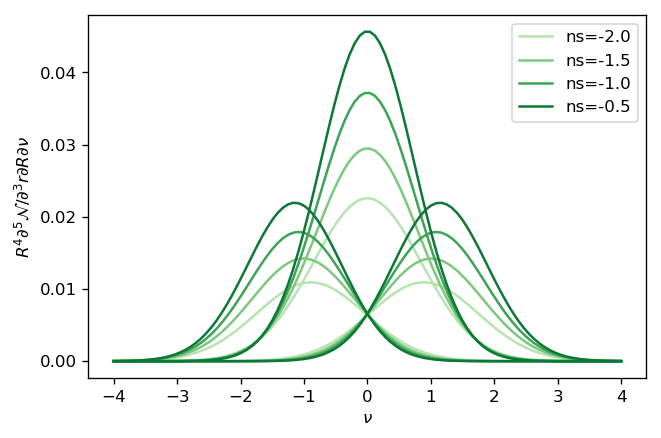

In [47]:
plt.figure(dpi=120)
nugrid = np.linspace(-4, 4, 100)

for i, ns in enumerate((-2., -1.5, -1., -0.5)):
    f = 0.3
    c = mpl.cm.Greens(f + (1-f)*i/4)
    plt.plot(nugrid, N_PS(nugrid, ns), label=f'ns={ns}', c=c)
    plt.plot(nugrid, N_SS(nugrid, ns), label='', c=c)
    plt.plot(nugrid, N_SV(nugrid, ns), label='', c=c)

plt.xlabel(r'$\nu$')
plt.ylabel(r'$R^4 \partial^5 \mathcal{N}/\partial^3 r\partial R\partial \nu$')
plt.legend()

### Compare with Sandrine's results
She finds that
$$ N_\mathrm{PS} \propto \frac{1}{8 \sqrt{5} \pi ^{3/2} \left(6-5 \gamma ^2\right)^4 \left(5 \gamma ^2-9\right)^5}e^{\frac{\nu ^2}{2 \left(\gamma ^2-1\right)}} \left(-8 \sqrt{\pi } \left(5 \gamma ^2-9\right)^5 \left(6-5 \gamma ^2\right)^{7/2} e^{\frac{\gamma ^2 \nu ^2}{10 \gamma ^4-22 \gamma ^2+12}}+60 \left(5 \gamma ^2-9\right) \gamma  \sqrt{2-2 \gamma ^2} \left(6-5 \gamma ^2\right)^4 \nu  \left(275 \gamma ^4+30 \gamma ^2 \left(2 \nu ^2-23\right)+351\right)-2 \sqrt{\pi } \sqrt{9-5 \gamma ^2} \left(6-5 \gamma ^2\right)^4 e^{\frac{2 \gamma ^2 \nu ^2}{5 \gamma ^4-14 \gamma ^2+9}} \left(3600 \gamma ^4 \nu ^4+120 \left(35 \gamma ^2-27\right) \left(5 \gamma ^2-9\right) \gamma ^2 \nu ^2+\left(575 \gamma ^4-1230 \gamma ^2+783\right) \left(9-5 \gamma ^2\right)^2\right)-\frac{8 \sqrt{\pi } \left(5 \gamma ^2-9\right)^5 \left(6-5 \gamma ^2\right)^{7/2} e^{\frac{\gamma ^2 \nu ^2}{10 \gamma ^4-22 \gamma ^2+12}} (\text{erf} (\gamma  \nu ))}{\sqrt{2} \sqrt{5 \gamma ^4-11 \gamma ^2+6}}-\frac{2 \sqrt{\pi } \sqrt{9-5 \gamma ^2} \left(6-5 \gamma ^2\right)^4 e^{\frac{2 \gamma ^2 \nu ^2}{5 \gamma ^4-14 \gamma ^2+9}} \left(3600 \gamma ^4 \nu ^4+120 \left(35 \gamma ^2-27\right) \left(5 \gamma ^2-9\right) \gamma ^2 \nu ^2+\left(575 \gamma ^4-1230 \gamma ^2+783\right) \left(9-5 \gamma ^2\right)^2\right) \left(\text{erf} \left(\sqrt{2} \gamma  \nu \right)\right)}{\sqrt{5 \gamma ^4-14 \gamma ^2+9}}\right),$$

and $$ N_\mathrm{SS} \propto \frac{2 e^{\frac{3 \nu ^2}{5 \gamma ^2-6}}}{\pi  \sqrt{30-25 \gamma ^2}}.$$

Let us compare the result of the direct integration of
$$ \langle \lambda_1 \lambda_2 \delta(\lambda_3) \delta(x-\nu)\rangle$$
and 
$$ \langle -\lambda_1 \lambda_3 \delta(\lambda_2) \delta(x-\nu)\rangle.$$

In [228]:
def N_PS_sandrine(nu, ns):
    from scipy.special import erf
    gamma = np.sqrt((ns+3)/(ns+5))
    return (
        (np.exp(nu**2/(2.*(-1 + gamma**2)))*(
            60*gamma*(6 - 5*gamma**2)**4*np.sqrt(2 - 2*gamma**2)*(-9 + 5*gamma**2)*nu*
            (351 + 275*gamma**4 + 30*gamma**2*(-23 + 2*nu**2)) - 
            8*np.exp((gamma**2*nu**2)/(12 - 22*gamma**2 + 10*gamma**4))
            *(6 - 5*gamma**2)**3.5*(-9 + 5*gamma**2)**5*np.sqrt(np.pi) -
            2*np.exp((2*gamma**2*nu**2)/(9 - 14*gamma**2 + 5*gamma**4))*
            (6 - 5*gamma**2)**4*np.sqrt(9 - 5*gamma**2)*
            ((9 - 5*gamma**2)**2*(783 - 1230*gamma**2 + 575*gamma**4) +
             120*gamma**2*(-9 + 5*gamma**2)*(-27 + 35*gamma**2)*nu**2 + 
             3600*gamma**4*nu**4)*np.sqrt(np.pi) - 
            2*np.exp((2*gamma**2*nu**2)/(9 - 14*gamma**2 + 5*gamma**4))*(6 - 5*gamma**2)**4*np.sqrt(9 - 5*gamma**2)*
            ((9 - 5*gamma**2)**2*(783 - 1230*gamma**2 + 575*gamma**4) + 120*gamma**2*(-9 + 5*gamma**2)*
             (-27 + 35*gamma**2)*nu**2 + 3600*gamma**4*nu**4)*np.sqrt(np.pi)*
            erf((gamma*nu)/np.sqrt(4.5 - 7*gamma**2 + (5*gamma**4)/2.)) -
            8*np.exp((gamma**2*nu**2)/(12 - 22*gamma**2 + 10*gamma**4))*(6 - 5*gamma**2)**3.5*
            (-9 + 5*gamma**2)**5*np.sqrt(np.pi)*erf((gamma*nu)/(np.sqrt(2)*np.sqrt(6 - 11*gamma**2 + 5*gamma**4)))))/
        (8.*np.sqrt(5)*(6 - 5*gamma**2)**4*(-9 + 5*gamma**2)**5*np.pi**1.5))

def N_SS_sandrine(nu, ns):
    from scipy.special import erf
    gamma = np.sqrt((ns+3)/(ns+5))
    return (2*np.exp((3*nu**2)/(-6 + 5*gamma**2)))/(np.sqrt(30 - 25*gamma**2)*np.pi)

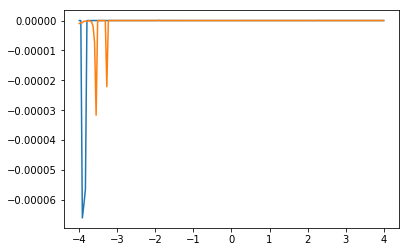

In [243]:
nugrid = np.linspace(-4, 4, 200)
ns = -0.5
def plot(x, y1, y2):
    rmean = np.median(y1/y2)
    plt.plot(x, y1/y2/rmean - 1)
plot(nugrid, N_PS_sandrine(nugrid, ns) * oddpart(ns), N_PS(nugrid, ns))
plot(nugrid, N_SS_sandrine(nugrid, ns) * oddpart(ns), N_SS(nugrid, ns))

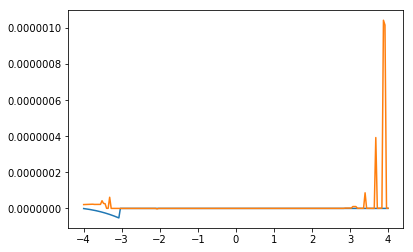

In [244]:
nugrid = np.linspace(-4, 4, 200)
ns = -2.
def plot(x, y1, y2):
    rmean = np.median(y1/y2)
    plt.plot(x, y1/y2/rmean - 1)
plot(nugrid, N_PS_sandrine(nugrid, ns) * oddpart(ns), N_PS(nugrid, ns))
plot(nugrid, N_SS_sandrine(nugrid, ns) * oddpart(ns), N_SS(nugrid, ns))

## Compare to cubes

In [220]:
np.diff(smoothing_scales) / smoothing_scales[1:]

array([0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601, 0.05930601,
       0.05930601, 0.05930601, 0.05930601, 0.05930601])

ns=-2.0: x_correction=0.935 factor=19.1
ns=-2.0: x_correction=0.999 factor=19.6
ns=-2.0: x_correction=0.931 factor=19.7
ns=-1.5: x_correction=0.942 factor=16.8
ns=-1.5: x_correction=0.951 factor=16.5
ns=-1.5: x_correction=0.920 factor=16.3
ns=-1.0: x_correction=0.941 factor=17.2
ns=-1.0: x_correction=0.910 factor=16.2
ns=-1.0: x_correction=0.942 factor=16.9
ns=-0.5: x_correction=0.948 factor=19.0
ns=-0.5: x_correction=0.921 factor=18.5
ns=-0.5: x_correction=0.937 factor=19.0


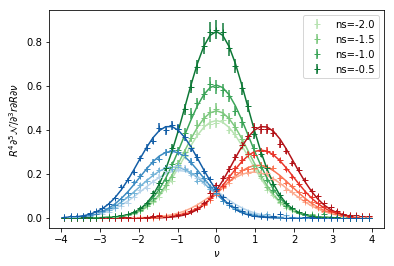

In [214]:
lines = []
all_ns = (-2., -1.5, -1.0, -0.5)
# all_ns = (-2, -1)
for i, ns in enumerate(all_ns):
    arg = 0.3 + 0.7 * i / len(all_ns)
    c_PS = mpl.cm.Reds(arg)
    c_SS = mpl.cm.Greens(arg)
    c_SV = mpl.cm.Blues(arg)
    
    data = (fourdens0, fourdens1, fourdens2)
    errors = (err0, err1, err2)
    colors = (c_PS, c_SS, c_SV)
    th_curves = (N_PS, N_SS, N_SV)
    for i  in range(3):
        exp = data[i]
        err = errors[i]
        color = colors[i]
        th = th_curves[i]

        fit_fun = lambda x, a, b: b*th(a*x, ns)
        mask = np.isfinite(err[ns])
        popt, pcov = curve_fit(fit_fun, x[mask], exp[ns][mask], p0=[.95, 17])  #, sigma=err[ns][mask])

        label = f'ns={ns}' if i == 1 else ''
        plt.errorbar(x, exp[ns], linestyle='', marker='+', c=color, label=label, yerr=err[ns], fmt='')
        plt.plot(x, fit_fun(x, *popt), c=color, label='')
        print(f'ns={ns}: x_correction={popt[0]:.3f} factor={popt[1]:.1f}')
            
# labelLines(lines, xvals=(0, 0), align=False, backgroundcolor='none')
plt.legend()
        
plt.xlabel(r'$\nu$')
plt.ylabel(r'$R^4 \partial^5 \mathcal{N}/\partial^3 r\partial R\partial \nu$')
plt.savefig('plot/PDF_th_vs_cube.pdf')

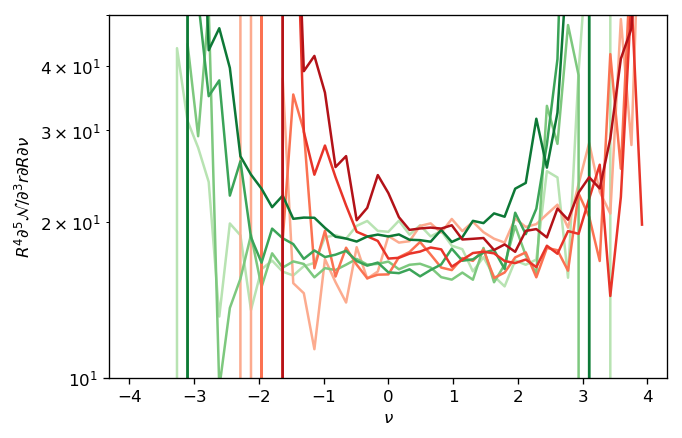

In [247]:
plt.figure(dpi=120)
nugrid = np.linspace(-4, 4, 100)

correction = 1/0.94
Ni = 4
for i, ns in enumerate((-2., -1.5, -1., -0.5)):
    f = 0.3
    x = (nubins[1:]+nubins[:-1])/2
    color = cmap.Greens(i / Ni*(1-f)+f)
    plt.plot(x, fourdens1[ns] / N_SS(x/correction, ns), c=color)
    color = cmap.Reds(i / Ni*(1-f)+f)
    plt.plot(x, fourdens0[ns] / N_PS(x/correction, ns), c=color)

plt.xlabel(r'$\nu$')
plt.ylabel(r'$R^4 \partial^5 \mathcal{N}/\partial^3 r\partial R\partial \nu$')

plt.ylim(10, 50)
plt.yscale('log')

Text(0, 0.5, '$\\partial^5 \\mathcal{N}\\ /\\ \\partial \\nu\\partial r^3\\partial R$')

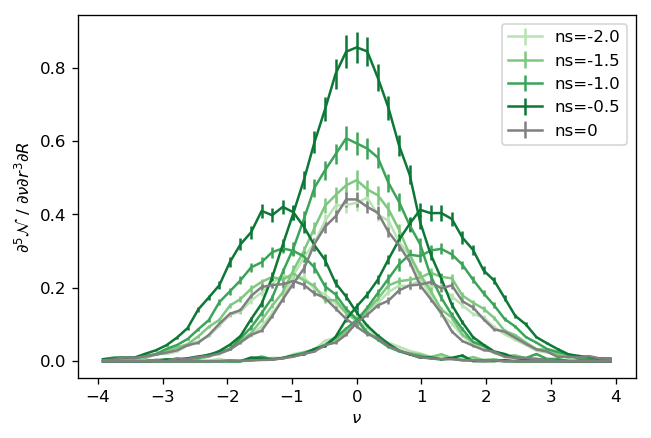

In [177]:
plt.figure(dpi=120)

Ni = len(fourdens0.keys())-1
ns_list = sorted(list(fourdens0.keys()))#[:-1]

scale = 1
for i, ns in enumerate(ns_list):
    f = 0.3
    color = cmap.Greens(i / Ni*(1-f)+f)
    x = (nubins[1:]+nubins[:-1])/2
    if ns == 0:
        color = 'grey'
    plt.errorbar(x, fourdens1[ns], yerr=err1[ns], color=color, label=f'ns={ns}')
    plt.errorbar(x, fourdens0[ns], yerr=err0[ns], color=color)
    plt.errorbar(x, fourdens2[ns], yerr=err2[ns], color=color)
    
plt.legend()
plt.xlabel(r'$\nu$')
plt.ylabel(r'$\partial^5 \mathcal{N}\ /\ \partial \nu\partial r^3\partial R$')

/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


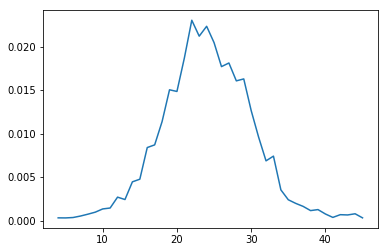

In [186]:
plt.plot(np.std(tmp1[-2], axis=0) / w1[-2])

Text(0, 0.5, '$\\partial^5 \\mathcal{N}\\ /\\ \\partial \\nu\\partial r^3\\partial R$')

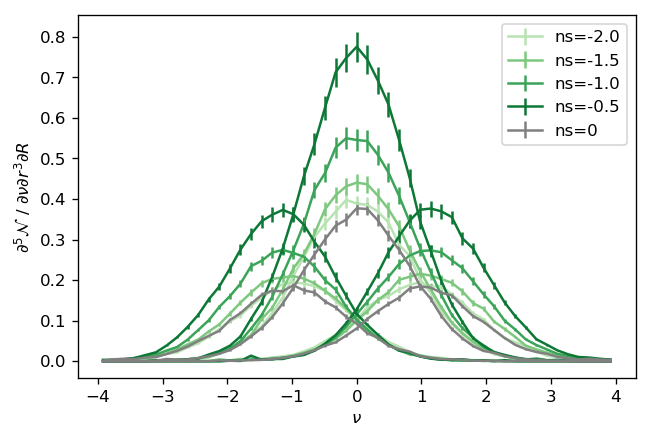

In [21]:
plt.figure(dpi=120)

Ni = len(fourdens0.keys())-1
ns_list = sorted(list(fourdens0.keys()))#[:-1]

scale = 1
for i, ns in enumerate(ns_list):
    f = 0.3
    color = cmap.Greens(i / Ni*(1-f)+f)
    x = (nubins[1:]+nubins[:-1])/2
    if ns == 0:
        color = 'grey'
    plt.errorbar(x, fourdens1[ns], yerr=err1[ns], color=color, label=f'ns={ns}')
    plt.errorbar(x, fourdens0[ns], yerr=err0[ns], color=color)
    plt.errorbar(x, fourdens2[ns], yerr=err2[ns], color=color)
    
plt.legend()
plt.xlabel(r'$\nu$')
plt.ylabel(r'$\partial^5 \mathcal{N}\ /\ \partial \nu\partial r^3\partial R$')

Text(0, 0.5, '$\\partial^5 \\mathcal{N}\\ /\\ \\partial \\nu\\partial r^3\\partial R$')

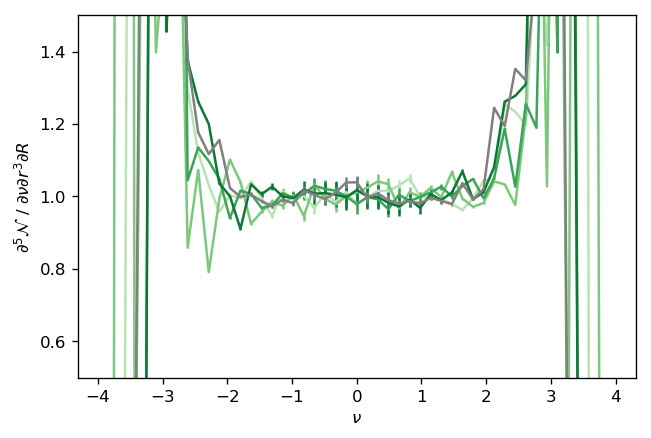

In [16]:
plt.figure(dpi=120)

Ni = len(fourdens0.keys())-1
ns_list = sorted(list(fourdens0.keys()))#[:-1]

scale = 1
resls = []
nsls = []
for i, ns in enumerate(ns_list):
    f = 0.3
    color = cmap.Greens(i / Ni*(1-f)+f)
    x = (nubins[1:]+nubins[:-1])/2
    if ns == 0:
        color = 'grey'
        
    mask = (x > -2) & (x < 2)
    popt, pcov = curve_fit(Nssnu, x[mask], fourdens1[ns][mask], p0=[ns, 2], sigma=err1[ns][mask])
    plt.errorbar(x, fourdens1[ns] / Nssnu(x, *popt), yerr=err1[ns], color=color)
    
    if ns < 0:
        resls.append(popt[0])
        nsls.append(ns)
    
plt.ylim(0.5, 1.5)
    
plt.xlabel(r'$\nu$')
plt.ylabel(r'$\partial^5 \mathcal{N}\ /\ \partial \nu\partial r^3\partial R$')

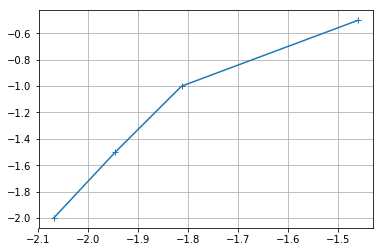

In [13]:
plt.plot(resls, nsls, '-+')
plt.grid(True)

In [44]:
df = ds.to_dataframe()
ds.attrs

OrderedDict([('Lbox', 100.0),
             ('dimensions', 256),
             ('cosmology', 'powerlaw'),
             ('spectral_index', -0.5),
             ('n_threads', 4),
             ('smoothing_scale', array([ 1, 20, 50])),
             ('seed', 1100227169),
             ('verbose', 'False')])

In [128]:
df[(df.R > 10) & (df.R < 11)].groupby('kind')['iR', 'R'].count()

iR     R
kind            
0      674   674
1     1337  1337
2      681   681

In [129]:
df[(df.R > 10) & (df.R < 11)].groupby('kind')['iR', 'R'].count() / (_dR/_R) / (_L/_R)**3

iR         R
kind                    
0     2.238585  2.238585
1     4.440635  4.440635
2     2.261834  2.261834

In [145]:
factor = 1/(_L**3 * _dR / _R**4)
(np.trapz(fourdens0[-0.5] * factor, x),
 np.trapz(fourdens1[-0.5] * factor, x),
 np.trapz(fourdens2[-0.5] * factor, x))

(0.0025641001413810316, 0.005087502717255139, 0.002474899793918718)

In [115]:
_Rmin = df[df.iR == 24].R.mean()
_dR = df[df.iR == 25].R.mean() - Rmin

_L = ds.attrs['Lbox']
_R = _Rmin
_dR = _dR
_dnu = np.diff(nubins)[0]
x = (nubins[1:]+nubins[:-1])/2
factor = _L**3 * _dR / _Rmin**4
(np.trapz(fourdens0[-0.5] * factor, x),
 np.trapz(fourdens1[-0.5] * factor, x),
 np.trapz(fourdens2[-0.5] * factor, x))

(232.43823925027226, 461.18720353209216, 224.35213864521342)

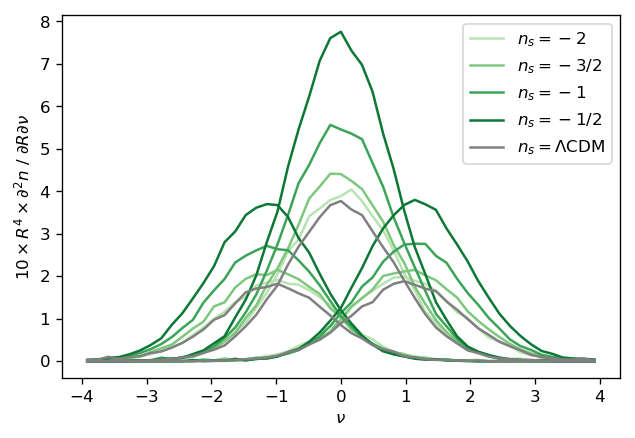

In [46]:
plt.figure(dpi=120)

Ni = len(fourdens0.keys())-1
ns_list = sorted(list(fourdens0.keys()))#[:-1]
labels = ['-2', '-3/2', '-1', '-1/2', '\mathrm{\Lambda CDM}']

scale = 1e1
for i, ns in enumerate(ns_list):
    f = 0.3
    color = cmap.Greens(i / Ni*(1-f)+f)
    x = (nubins[1:]+nubins[:-1])/2
    if ns == 0:
        color = 'grey'
#     plt.plot(x, scale*(fourdens0[ns]+fourdens2[ns][::-1])/2, c=color, label=f'$n_s={labels[i]}$')
#     plt.plot(x, scale*(fourdens1[ns]+fourdens1[ns][::-1])/2, c=color)
#     plt.plot(x, scale*(fourdens2[ns]+fourdens0[ns][::-1])/2, c=color)
    
    plt.plot(x, scale*fourdens0[ns], c=color, label=f'$n_s={labels[i]}$')
    plt.plot(x, scale*fourdens1[ns], c=color)
    plt.plot(x, scale*fourdens2[ns], c=color)

plt.legend()
plt.xlabel(r'$\nu$')
plt.ylabel(r'$10\times R^4\times\partial^2n\ /\ \partial R \partial \nu$')
plt.savefig('plot/critical_event_height_PDF.pdf')

Number ratio (integrating distribution)

In [134]:
np.nanmean(np.sqrt(err0[-0.5]**2 + err1[-0.5]**2))

0.016819730740006613

In [49]:
for ns in [0, -.5, -1., -1.5, -2.]:
    N0 = np.trapz(fourdens0[ns], x)
    N1 = np.trapz(fourdens1[ns], x)
    N2 = np.trapz(fourdens2[ns], x)
    print('%4.1f\tratio=%.2f' % (ns, N1 / (N0 + N2) * 2))

 0.0	ratio=2.01
-0.5	ratio=2.02
-1.0	ratio=2.02
-1.5	ratio=2.03
-2.0	ratio=2.03


Number ratio (using total number)

In [53]:
for ns, ds in all_ds_by_ns.items():
    N0 = (ds.kind==0).sum()
    N1 = (ds.kind==1).sum()
    N2 = (ds.kind==2).sum()
    
    if ns == 0: ns = 'LCDM'
    # ratio = float(2 * N1 / (N0 + N2))
    ratio = float(N1 / N2)
    err = float(np.sqrt(1/N1+1/N2) * ratio)
    print(f'ns={ns},  {ratio:.2f} ± {err:.2f} (N0/N2={100*float(N0 / N2):.1f}%)')

ns=LCDM,  2.09 ± 0.01 (N0/N2=99.9%)
ns=-2.0,  2.09 ± 0.01 (N0/N2=99.2%)
ns=-1.5,  2.13 ± 0.01 (N0/N2=101.9%)
ns=-1.0,  2.12 ± 0.01 (N0/N2=101.6%)
ns=-0.5,  2.11 ± 0.00 (N0/N2=100.5%)


In [8]:
float(N1) / float(N2), float(N1) / float(N0), 1/(float(N0)/float(N2))

(2.0716651066714005, 2.141459704002242, 1.0336900964861944)

In [534]:
gamma = 0.5773535265643923
gammatilde = 0.7745966692414835
Rstar, Rtilde = np.sqrt(2/3), np.sqrt(2/5)
R = 1
def n_th(nu):
    y = gamma
    yt = gammatilde
    return (3*np.sqrt(3)*(1-yt**2)*(25*y**4+30*y**2*(2*nu**2-1)-27) * R) / (20 * np.sqrt(10) * np.pi**(5/2) * (9-5*y**2)**(5/2) * Rstar**3 * Rtilde**2) * np.exp(-9*nu**2 / (2*(9-5*y**2)))

In [535]:
n_th(nubins)

array([ 9.21942970e-07,  1.84052205e-06,  3.53768172e-06,  6.54256989e-06,
        1.16326287e-05,  1.98642238e-05,  3.25372230e-05,  5.10384390e-05,
        7.65046401e-05,  1.09263996e-04,  1.48066610e-04,  1.89203919e-04,
        2.25731163e-04,  2.47113555e-04,  2.39663228e-04,  1.88064024e-04,
        7.80602003e-05, -9.99712872e-05, -3.47253311e-04, -6.53651937e-04,
       -9.96606342e-04, -1.34273677e-03, -1.65229352e-03, -1.88579009e-03,
       -2.01141443e-03, -2.01141443e-03, -1.88579009e-03, -1.65229352e-03,
       -1.34273677e-03, -9.96606342e-04, -6.53651937e-04, -3.47253311e-04,
       -9.99712872e-05,  7.80602003e-05,  1.88064024e-04,  2.39663228e-04,
        2.47113555e-04,  2.25731163e-04,  1.89203919e-04,  1.48066610e-04,
        1.09263996e-04,  7.65046401e-05,  5.10384390e-05,  3.25372230e-05,
        1.98642238e-05,  1.16326287e-05,  6.54256989e-06,  3.53768172e-06,
        1.84052205e-06,  9.21942970e-07])

In [536]:
def th(nu, ns=-2):
    y = np.sqrt((ns+3)/(ns+5))
    yt = np.sqrt((ns+5)/(ns+7))
#     return (-3*np.sqrt(3/10)*np.exp((9*nu**2)/(2.*(-9 + 5*y**2)))*(-1 + yt**2)*(63423 + 14375*y**8 + 4860*y**2*(-35 + 6*nu**2)
#                                                                      + 1500*y**6*(-55 + 14*nu**2) + 450*y**4*(
#                                                                          393 - 120*nu**2 + 8*nu**4)))/(40.*np.pi**4.5*(9 - 5*y**2)**(9/2))
    return (-9*np.sqrt(3/10)*np.exp((9*nu**2)/(2.*(-9 + 5*y**2)))*(-1 + yt**2)*(-27 + 25*y**4 + 30*y**2*(-1 + 2*nu**2)))/(8.*np.pi**4.5*(9 - 5*y**2)**2.5)

Text(0, 0.5, '$10 R^4\\times\\partial^2n\\ /\\ \\partial R \\partial \\nu$')

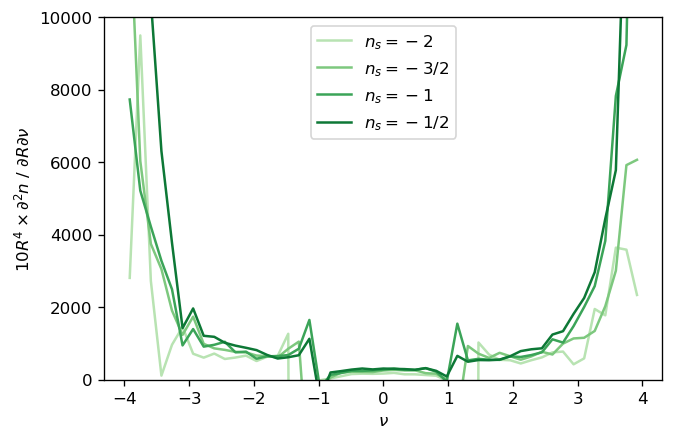

In [537]:
plt.figure(dpi=120)

Ni = len(fourdens0.keys())-1
ns_list = sorted(list(fourdens0.keys()))[:-1]
labels = ['-2', '-3/2', '-1', '-1/2', '\mathrm{\Lambda CDM}']

scale = 10
for i, ns in enumerate(ns_list):
    f = 0.3
    color = cmap.Greens(i / Ni*(1-f)+f)
    x = (nubins[1:] + nubins[:-1]) / 2
    plt.plot(x, (fourdens0[ns]-fourdens1[ns]+fourdens2[ns]) / th(x, ns=ns),
             c=color, label=f'$n_s={labels[i]}$')
    
# plt.plot(x, th(x))

plt.ylim(0, 10000)

plt.legend()
plt.xlabel(r'$\nu$')
plt.ylabel(r'$10 R^4\times\partial^2n\ /\ \partial R \partial \nu$')

## Check that the smoothed field have correct variance

In [3]:
ls data

10_crit_events.nc  21_crit_events.nc  31_crit_points.nc  43_crit_events.nc
10_crit_points.nc  21_crit_points.nc  32_crit_events.nc  43_crit_points.nc
11_crit_events.nc  22_crit_events.nc  32_crit_points.nc  44_crit_events.nc
11_crit_points.nc  22_crit_points.nc  33_crit_events.nc  44_crit_points.nc
11_field.nc        23_crit_events.nc  33_crit_points.nc  5_crit_events.nc
12_crit_events.nc  23_crit_points.nc  34_crit_events.nc  5_crit_points.nc
12_crit_points.nc  24_crit_events.nc  34_crit_points.nc  6_crit_events.nc
13_crit_events.nc  24_crit_points.nc  35_crit_events.nc  6_crit_points.nc
13_crit_points.nc  25_crit_events.nc  35_crit_points.nc  7_crit_events.nc
14_crit_events.nc  25_crit_points.nc  36_crit_events.nc  7_crit_points.nc
14_crit_points.nc  26_crit_events.nc  36_crit_points.nc  8_crit_events.nc
15_crit_events.nc  26_crit_points.nc  37_crit_events.nc  8_crit_points.nc
15_crit_points.nc  27_crit_events.nc  37_crit_points.nc  9_crit_events.nc
16_crit_events.nc  27_crit_points.

In [34]:
ds = xarray.open_dataset('data/11_crit_events.nc')

In [25]:
v = ds.density.values
all_std = []
for iR, R in enumerate(tqdm(ds.R.values)):
    all_std.append(np.std(ds.density.values[..., iR]))

In [36]:
plt.plot(RR*pix2Mpc, all_std)

NameError: name 'pix2Mpc' is not defined

In [39]:
ss, RR = np.unique(ds.sigma), np.unique(ds.R)[::-1]
all_RR = np.geomspace(*ds.attrs['smoothing_scale'])

In [41]:
from scipy.special import spherical_jn

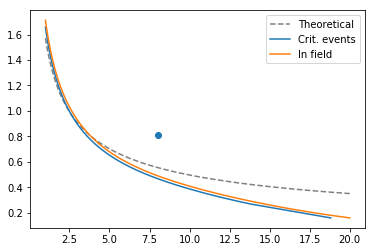

In [47]:
k = np.geomspace(1e-4, 1e4, 10_000)
Pk = k**-2
ss_th = []
pix2Mpc = ds.attrs['Lbox'] / ds.attrs['dimensions']
R8 = 8
fact = np.sqrt(np.trapz(k**2*Pk/(2*np.pi**2) * (3*spherical_jn(1, k*R8)/(k*R8))**2, k)) / 0.81
for R in all_RR:
    new_sigma = np.sqrt(np.trapz(k**2*Pk/(2*np.pi**2) * np.exp(-(k*R)**2), k)) / fact
    ss_th.append(new_sigma)
    
plt.plot(all_RR, ss_th, '--', c='grey', label='Theoretical')

plt.plot(RR*pix2Mpc, ss, label='Crit. events')
plt.plot(all_RR, all_std, label='In field')
plt.legend()
plt.scatter(8, 0.81)

In [128]:
ds.where(ds.kind == 1, drop=True)

<xarray.Dataset>
Dimensions:  (index: 30106)
Coordinates:
  * index    (index) int64 1157 1158 1159 1160 1161 ... 43645 43646 43648 43649
Data variables:
    kind     (index) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    iR       (index) float64 1.0 1.0 1.0 1.0 1.0 ... 43.0 44.0 44.0 49.0 49.0
    R        (index) float64 2.56 2.56 2.56 2.56 ... 35.48 35.48 48.16 48.16
    l1       (index) float64 -0.1795 -0.1906 -0.1158 ... -0.0001457 -0.0001457
    l2       (index) float64 -0.001931 0.002608 0.01376 ... 5.656e-07 5.656e-07
    l3       (index) float64 0.06413 0.0419 0.227 ... 8.238e-05 8.238e-05
    h11      (index) float64 -0.1368 -0.1488 0.01404 ... -6.343e-05 -6.343e-05
    h22      (index) float64 -0.03493 -0.05059 0.02029 ... 6.937e-05 6.937e-05
    h33      (index) float64 0.007988 0.001963 0.03897 ... -6.997e-05 -6.997e-05
    h12      (index) float64 -0.07819 -0.06739 0.03462 ... 3.672e-05 3.672e-05
    h13      (index) float64 0.03956 0.03285 -0.111 ... -6.

# Sandbox

In [73]:
ds = all_ds[5]
ds0 = ds.where(ds.kind == 0, drop=True)
ds1 = ds.where(ds.kind == 1, drop=True)
ds2 = ds.where(ds.kind == 2, drop=True)

ds

<xarray.Dataset>
Dimensions:       (index: 52436)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 ... 52431 52432 52433 52434 52435
Data variables:
    kind          (index) int64 0 0 0 0 0 0 0 0 0 0 0 ... 2 0 0 1 1 0 2 0 1 1 0
    iR            (index) int64 1 1 1 1 1 1 1 1 1 ... 43 43 43 44 44 45 45 45 46
    R             (index) float64 2.56 2.56 2.56 2.56 ... 37.71 37.71 40.09
    l1            (index) float64 ...
    l2            (index) float64 ...
    l3            (index) float64 ...
    h11           (index) float64 ...
    h22           (index) float64 ...
    h33           (index) float64 ...
    h12           (index) float64 ...
    h13           (index) float64 ...
    h23           (index) float64 ...
    dens          (index) float64 ...
    Fx11          (index) float64 ...
    Fx22          (index) float64 ...
    Fx33          (index) float64 ...
    x             (index) float64 ...
    y             (index) float64 ...
    z             (index) float64 ..

In [39]:
X0 = ds0[['x', 'y', 'z']].to_array().T
X1 = ds1[['x', 'y', 'z']].to_array().T
X2 = ds2[['x', 'y', 'z']].to_array().T

In [40]:
tree0 = KDTree(X0, metric='euclidean_periodic', L=256)
tree1 = KDTree(X1, metric='euclidean_periodic', L=256)
tree2 = KDTree(X2, metric='euclidean_periodic', L=256)

In [41]:
np.unique(ds.R, return_counts=True)

(array([ 2.56      ,  2.7213951 ,  2.89296534,  3.07535222,  3.26923768,
         3.47534664,  3.69444972,  3.92736616,  4.1749668 ,  4.43817741,
         4.71798212,  5.01542711,  5.33162451,  5.66775656,  6.02508005,
         6.40493098,  6.80872959,  7.23798567,  7.69430418,  8.17939128,
         8.69506067,  9.24324042,  9.82598013, 10.44545865, 11.10399217,
        11.80404291, 12.54822831, 13.33933086, 14.18030843, 15.0743054 ,
        16.02466437, 17.03493869, 18.10890571, 19.25058093, 20.46423303,
        21.75439977, 23.12590502, 24.58387676, 26.13376628, 27.78136851,
        29.53284377, 31.3947407 , 33.37402086, 35.47808465, 40.09252703,
        45.30714496]),
 array([15640, 12766, 10058,  8375,  6589,  5354,  4425,  3708,  3008,
         2338,  1950,  1642,  1293,  1063,   919,   639,   572,   449,
          359,   338,   223,   204,   153,   156,   114,   108,    90,
           79,    76,    37,    48,    45,    29,    23,    16,    22,
            9,     8,     9,     9, 

In [43]:
dens_bins = np.arange(0, 7, .5)
Ndbins = len(dens_bins)
Nbins = 50
rbins = np.geomspace(0.5, 10, Nbins)
xi00 = np.zeros((Ndbins, Nbins))
xi10 = np.zeros((Ndbins, Nbins))
xi11 = np.zeros((Ndbins, Nbins))

deltad = 0.5
for i, (dmin, dmax) in enumerate(zip(dens_bins[:-1], tqdm(dens_bins[1:]))):
    X0, t0 = get_tree(ds, 0, dmin, dmax)
    X1, t1 = get_tree(ds, 1, dmin-deltad, dmax-deltad)
    
    if t0 is not None:
        xi00[i, :] = t0.count_neighbors(t0, r=rbins, cumulative=False)
        if t1 is not None:
            xi10[i, :] = t0.count_neighbors(t1, r=rbins, cumulative=False)
    if t1 is not None:
        xi11[i, :] = t1.count_neighbors(t1, r=rbins, cumulative=False)
        
xi00[:, 0] = 0  # ((ds.kind == 0) & (ds.dens > dens_bins[0])).sum()
xi11[:, 0] = 0  # ((ds.kind == 1) & (ds.dens > dens_bins[0]-deltad)).sum()

/home/ccc/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:2575: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  self.apply_aspect()
/home/ccc/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  self.apply_aspect()
/home/ccc/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:848: UserWarning: aspect is not supported for Axes with xscale=log, yscale=linear
  self.apply_aspect()


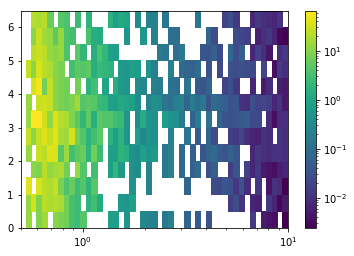

In [44]:
plt.pcolormesh(rbins, dens_bins, xi00 / rbins**3, norm=LogNorm())
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal')
plt.xscale('log')

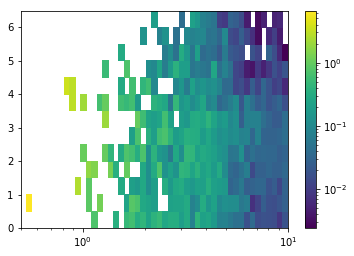

In [45]:
plt.pcolormesh(rbins, dens_bins, xi10 / rbins**3, norm=LogNorm())
plt.colorbar()
ax = plt.gca()
ax.set_aspect('equal')
plt.xscale('log')

In [98]:
(ds.kind == 0).sum()

<xarray.DataArray 'kind' ()>
array(8262)

# Number count of critical points

In [5]:
all_files = sorted(glob('data/*_crit_points.nc'), key=lambda e: int(e.split('/')[-1].split('_')[0]))
all_ds = []
all_ds_by_ns = defaultdict(list)
k = np.geomspace(1e-4, 1e4, 1000)
Rmin = 1
Rmax = 5
for f in tqdm(all_files):
    ds = xarray.open_dataset(f)
    pix2Mpc = ds.attrs["Lbox"] / ds.attrs['dimensions']
    fh = field.FieldHandler(Ndim=3, Lbox=ds.attrs['Lbox'], dimensions=16,
                            Pk=(k, k**ds.attrs['spectral_index']), filter=filters.GaussianFilter(radius=1))
    smoothing_scales = np.geomspace(*ds.attrs['smoothing_scale'])
    sigma = np.array([fh.sigma(0, filters.GaussianFilter(radius=R*pix2Mpc)) for R in smoothing_scales])
    
    # ds['sigma'] = dummy_val + sigma[ds.iR] 
    # ds['nu'] = ds['dens'] / ds['sigma']
    R = ds.R * pix2Mpc
    pix2Mpc = ds.attrs['Lbox'] / ds.attrs['dimensions']
    Vbox = ds.attrs['Lbox']**3

    all_ds.append(ds)
    all_ds_by_ns[ds.attrs["spectral_index"]].append(ds)

for k in all_ds_by_ns:
    new = xarray.auto_combine(all_ds_by_ns[k])
    new.attrs.update(all_ds_by_ns[k][0].attrs)
    all_ds_by_ns[k] = new
critical_points = all_ds_by_ns

Got 0.018258130353745617
Got 0.01886357538102067
Got 0.016735068555362588
Got 0.01597568010554246
Got 0.016201672545019124
Got 0.017752180594149645
Got 0.01325687170434412
Got 0.018449030316547432
Got 0.015026122223426919
Got 0.014889849995774404
Got 0.014858520384418985
Got 0.014077820292112748
Got 0.014286150313930306
Got 0.013297732026113134
Got 0.018544266144902975
Got 0.016088205191175244
Got 0.013392976621692976
Got 0.01485577514884119
Got 0.013915977712613343
Got 0.018737842973543542
Got 0.013650143336243838
Got 0.015999752308832948
Got 0.015097846066401547
Got 0.013596028387377966
Got 0.017924274763777063
Got 0.01404081726422721
Got 0.013504823519158509
Got 0.01620688272619467
Got 0.01480641668253357
Got 0.01364133317568664
Got 0.013702108866822627
Got 0.018395991857913692
Got 0.015894984126446007
Got 0.015073263070154694
Got 0.013967021649053621
Got 0.01340436151615714
Got 0.01852319373770993
Got 0.01618673085645613
Got 0.014950222437618881
Got 0.013889905197584944
Got 0.01335

In [7]:
ds = all_ds_by_ns[-2.0]
df = ds.to_dataframe()

In [8]:
tmp = df.groupby(['kind', 'R'])['x'].describe().loc[:, 'count']
data = {}
for k in range(4):
    data[k] = tmp.loc[k].astype(int)

Let $N_\mathrm{P}, N_\mathrm{F}, N_\mathrm{W}, N_\mathrm{V}$ be the number of peaks, filaments, walls and voids respectively (of _any_ heigth). The number of critical events can be deduced from the derivatives of theses quantities. We know that
$$
N_\mathrm{PF} = \frac{\mathrm{d}N_\mathrm{P}}{\mathrm{d}R},
$$
and
$$
N_\mathrm{WV} = \frac{\mathrm{d}N_\mathrm{V}}{\mathrm{d}R}.
$$
The number of filament disappearing is then
$$
\frac{\mathrm{d}N_\mathrm{F}}{\mathrm{d}R} = N_\mathrm{PF} + N_\mathrm{FW},
$$
so that we can compute $N_\mathrm{FW}$ using
$$
N_\mathrm{FW} = \frac{\mathrm{d}N_\mathrm{F}}{\mathrm{d}R} - N_\mathrm{PF}.
$$

In [9]:
NP = data[0].values
NF = data[1].values
NW = data[2].values
NV = data[3].values
R = data[0].index.values

In [10]:
NPF = np.gradient(NP, R)
NWV = np.gradient(NV, R)
NFW = np.gradient(NF, R) - NPF
NFW2 = np.gradient(NW, R) - NWV

In [12]:
NP

array([65687, 53997, 44294, 36369, 29861, 24500, 20060, 16534, 13576,
       11179,  9257,  7700,  6320,  5304,  4415,  3623,  2966,  2490,
        2043,  1705,  1439,  1168,  1003,   824,   677,   572,   476,
         395,   323,   268,   220,   192,   163,   132,   116,   100,
          84,    72,    60,    51,    42,    37,    32,    26,    19,
          17,    15,    13,    12,     9])

In [14]:
x = np.concatenate((R, R))
y = np.concatenate((NFW/NPF, NFW2/NWV))
sigma = np.concatenate((np.sqrt(1/NF**2 + 1/NP**2), np.sqrt(1/NW**2 + 1/NV**2)))
mask = (x > 4) #& (np.concatenate((NPF, NV)) > 100)

f = lambda x, a: a * np.ones_like(x)
# popt, pcov = curve_fit(f, x, y, p0=[2.04])
popt, pcov = curve_fit(f, x[mask], y[mask], p0=[2.04], sigma=sigma[mask])

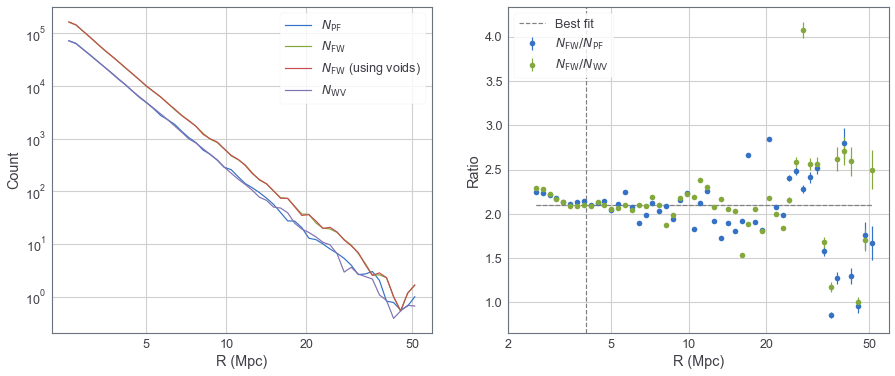

In [16]:
fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(15, 6))
axes[0].loglog(R, -NPF, label=r'$N_\mathrm{PF}$')
axes[0].loglog(R, -NFW, label=r'$N_\mathrm{FW}$')
axes[0].loglog(R, -NFW2, label=r'$N_\mathrm{FW}$ (using voids)')
axes[0].loglog(R, -NWV, label=r'$N_\mathrm{WV}$')
kwa = dict(linestyle='none', marker='o')
axes[1].errorbar(R, NFW/NPF,  yerr=sigma[:50]*NFW/NPF, label='$N_\mathrm{FW} / N_\mathrm{PF}$', **kwa)
axes[1].errorbar(R, NFW2/NWV, yerr=sigma[50:]*NFW2/NWV, label='$N_\mathrm{FW} / N_\mathrm{WV}$', **kwa)
axes[1].plot(R, f(R, popt), '--', c='grey', label='Best fit')
axes[1].fill_between(R, f(R, popt+np.sqrt(pcov[0])), f(R, popt-np.sqrt(pcov[0])), alpha=0.5, color='grey')
axes[1].axvline(4, ls='--', c='gray')

for ax in axes: ax.set_xlabel('R (Mpc)')
axes[0].set_ylabel('Count')
axes[1].set_ylabel('Ratio')
axes[0].legend()
axes[1].legend(loc='upper left')
axes[1].set_xticks((2, 5, 10, 20, 50))
axes[1].set_xticklabels((2, 5, 10, 20, 50))

plt.savefig('plot/count_critical_events_using_finite_difference_on_critical_points.pdf')

In [17]:
f'{popt[0]:.3f}±{np.sqrt(pcov[0,0]):.3f}'

'2.098±0.005'

## Compare number of c. events vs. c. points per smoothing scale
Here we compare the derivative of critical events w.r.t. critical points to understand wtf is happening.

In [10]:
Ne = xarray.open_dataset('data/1_crit_events.nc').to_dataframe()
Np = xarray.open_dataset('data/1_crit_points.nc').to_dataframe()

In [11]:
# # Number of filament-peak c. event
# Ne = critical_events[-2.0].to_dataframe()
# Np = critical_points[-2.0].to_dataframe()
# Np['iR'] = np.digitize(Np.R, np.unique(Np.R))

In [12]:
Ne['mask'] = False
Ne_kR = Ne.sort_values(['kind', 'iR']).set_index(['kind', 'iR'])
Ne_kR.head()

R        l1        l2        l3       h11       h22       h33  \
kind iR                                                                     
0    1   2.56 -0.178512 -0.138646  0.001660 -0.189959 -0.048222 -0.127589   
     1   2.56 -0.239460 -0.184391 -0.003069 -0.066036 -0.208891 -0.155639   
     1   2.56 -0.138383 -0.080809  0.004962 -0.061657 -0.056090 -0.114142   
     1   2.56 -0.301980 -0.197663  0.024700 -0.009184 -0.174445 -0.216999   
     1   2.56 -0.198117 -0.044070 -0.000798 -0.099552 -0.135287 -0.008478   

              h12       h13       h23      dens      Fx11      Fx22      Fx33  \
kind iR                                                                         
0    1   0.008800 -0.024410 -0.071949  0.316904 -0.027157  0.002153 -0.018739   
     1  -0.044750  0.046055 -0.070744  3.001781  0.008641  0.001267  0.046191   
     1  -0.065028 -0.004001  0.039958 -0.028143  0.035528  0.021341  0.001866   
     1  -0.035351 -0.112306 -0.030609  2.231810  0.052231  0.014805  0.028982   
     1  -0.101802  0.031396  0.024175  2.773502 -0.002037 -0.008065 -0.001379   

                  x           y           z    sigma   mask  
kind iR                                                      
0    1     0.369413   13.586634   88.919994  1.76365  False  
     1   255.540478   73.629951   44.459636  1.76365  False  
     1   255.537553  152.450031   24.380368  1.76365  False  
     1   255.696832  239.835501   53.918385  1.76365  False  
     1     0.215108   46.584688  228.901944  1.76365  False

In [20]:
set(tt0.query_pairs(r=1000, output_type='ndarray')[:, 1])

{1, 2}

In [13]:
def select_good_ids(tree, dmax=0.5):
    N, Ndim = tree.data.shape
    pos = tree.data
    keep = np.ones(N, dtype=bool)
    ipairs = tree.query_pairs(r=dmax, output_type='ndarray')
    keep[ipairs[:, 1]] = False
    
    return cKDTree(tree.data[keep], boxsize=tree.boxsize), keep

for iR in tqdm(range(50)):
    ok = True
    for i in range(3):
        ok &= (i, iR) in Ne_kR.index
    if not ok:
        print(f'Skipping {iR}')
        continue
    t0 = cKDTree(Ne_kR.loc[(0, iR), ['x', 'y', 'z']].values, boxsize=256)
    t1 = cKDTree(Ne_kR.loc[(1, iR), ['x', 'y', 'z']].values, boxsize=256)
    t2 = cKDTree(Ne_kR.loc[(2, iR), ['x', 'y', 'z']].values, boxsize=256)

    # Remove pairs of critical points: keep smallest id for paris separated by less than dmax
    tt0, m0 = select_good_ids(t0)
    tt1, m1 = select_good_ids(t1)
    tt2, m2 = select_good_ids(t2)
    
    print(f'Dropping {m0.sum()+m1.sum()+m2.sum()}')

    Ne_kR.loc[(0, iR), 'mask'] = m0
    Ne_kR.loc[(1, iR), 'mask'] = m1
    Ne_kR.loc[(2, iR), 'mask'] = m2

Skipping 0
Dropping 4583
Dropping 3819
Dropping 3106
Dropping 2487
Dropping 2108
Dropping 1734
Dropping 1456
Dropping 1147
Dropping 969
Dropping 793
Dropping 733
Dropping 557
Dropping 461
Dropping 404
Dropping 347
Dropping 242
Dropping 211
Dropping 195
Dropping 154
Dropping 126
Dropping 103
Dropping 95
Dropping 86
Dropping 65
Dropping 64
Dropping 50
Dropping 32
Dropping 31
Dropping 29
Dropping 25
Dropping 27
Dropping 16
Dropping 17
Skipping 34
Dropping 5
Dropping 10
Skipping 37
Dropping 11
Skipping 39
Skipping 40
Skipping 41
Skipping 42
Skipping 43
Skipping 44
Skipping 45
Skipping 46
Skipping 47
Skipping 48
Skipping 49



In [478]:
Ne_counts = Ne_kR[Ne_kR['mask']].groupby(['kind', 'R'])['x'].count()
# Ne_counts = Ne.groupby(['kind', 'R'])['x'].count()
Np_counts = Np.groupby(['kind', 'R'])['x'].count()

In [479]:
Rgrid = Np_counts.loc[0].index
# Estimate number of critical event using critical points
dNp = -np.diff(Np_counts.loc[0]) # / np.diff(Rgrid)
dNf = -np.diff(Np_counts.loc[1]) # / np.diff(Rgrid)
dNw = -np.diff(Np_counts.loc[2]) # / np.diff(Rgrid)
dNv = -np.diff(Np_counts.loc[3]) # / np.diff(Rgrid)

/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


[-3.0243014   4.56840435]
[-2.89199175  4.47185441]


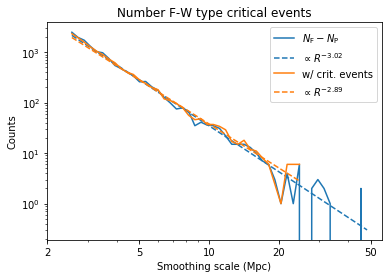

In [484]:
f = lambda x, a, b: a*x+b
# x, y = Rgrid[:-1], dNf-dNp
x, y = Rgrid[:-1], dNw-dNv
# x, y = Rgrid[:-1], (dNf+dNw-dNp-dNv) / 2
m = (y > 0) & (x > 5) & (x < 20) # mask out radii with no R
dy = 1/np.sqrt(y)
popt, pcov = curve_fit(f, np.log10(x[m]), np.log10(y[m]), sigma=dy[m])
print(popt)
plt.plot(x, y, label='$N_\mathrm{F}-N_\mathrm{P}$')
plt.plot(x, 10**f(np.log10(x), *popt), '--', c='C0', label=rf'$\propto R^{{{popt[0]:.2f}}}$')
# plt.plot(Rgrid[1:], dNf-dNp)

x, y = Ne_counts.loc[1].index, Ne_counts.loc[1]
m = (y > 0) & (x > 5) & (x < 20) # mask out radii with no R
dy = 1/np.sqrt(y)
popt, pcov = curve_fit(f, np.log10(x[m]), np.log10(y[m]), sigma=dy[m])
print(popt)
plt.plot(x, y, label='w/ crit. events')
plt.plot(x, 10**f(np.log10(x), *popt), '--', c='C1', label=rf'$\propto R^{{{popt[0]:.2f}}}$')
# plt.plot(Ne_counts.loc[1].index, Ne_counts.loc[1])
plt.loglog()
plt.legend()
plt.xticks(*[[2, 5, 10, 20, 50]]*2)
plt.xlabel('Smoothing scale (Mpc)')
plt.ylabel('Counts')
plt.title('Number F-W type critical events')

plt.savefig('plot/FW_critical_event_count.pdf')

/home/ccc/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[-2.90806445  4.15093156]
[-2.72879033  4.05704855]


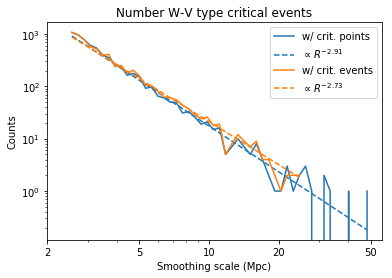

In [483]:
f = lambda x, a, b: a*x+b
x, y = Rgrid[:-1], dNv
dy = 1/np.sqrt(y)
m = (y > 0) & (x > 5) & (x < 20)
popt, pcov = curve_fit(f, np.log10(x[m]), np.log10(y[m]), sigma=dy[m])
print(popt)
plt.plot(x, y, label='w/ crit. points')
plt.plot(x, 10**f(np.log10(x), *popt), '--', c='C0', label=rf'$\propto R^{{{popt[0]:.2f}}}$')
# plt.plot(Rgrid[1:], dNf-dNp)

x, y = Ne_counts.loc[2].index, Ne_counts.loc[2]
dy = 1/np.sqrt(y)
m = (y > 0) & (x > 5) & (x < 20)
popt, pcov = curve_fit(f, np.log10(x[m]), np.log10(y[m]), sigma=dy[m])
print(popt)
plt.plot(x, y, label='w/ crit. events')
plt.plot(x, 10**f(np.log10(x), *popt), '--', c='C1', label=rf'$\propto R^{{{popt[0]:.2f}}}$')
# plt.plot(Ne_counts.loc[1].index, Ne_counts.loc[1])
plt.loglog()
plt.legend()
plt.xticks(*[[2, 5, 10, 20, 50]]*2)
plt.xlabel('Smoothing scale (Mpc)')
plt.ylabel('Counts')
plt.title('Number W-V type critical events')
plt.savefig('plot/WV_critical_event_count.pdf')

In [490]:
Ne_kR[Ne_kR['mask']].groupby('kind')['x'].count()

kind
0     6447
1    13362
2     6489
Name: x, dtype: int64

In [492]:
 13362 / ((6447 + 6489) / 2)

2.065862708719852